In [1]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 93% 24.0M/25.7M [00:00<00:00, 74.0MB/s]
100% 25.7M/25.7M [00:00<00:00, 66.5MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/imdb-dataset-of-50k-movie-reviews.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


## EDA and Preprocessing

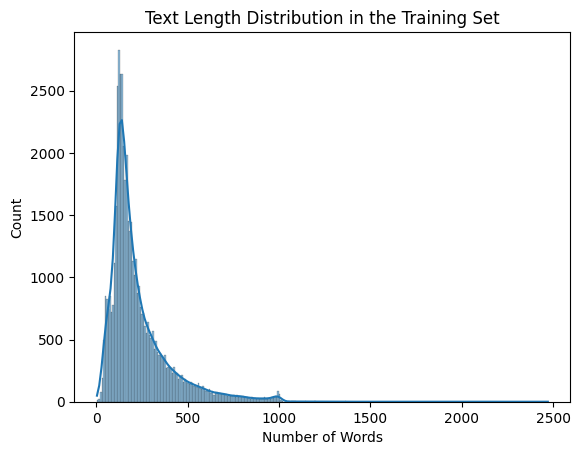

In [9]:
df['text_length'] = df['review'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
sns.histplot(df['text_length'], kde=True)
plt.title('Text Length Distribution in the Training Set')
plt.xlabel('Number of Words')
plt.show()


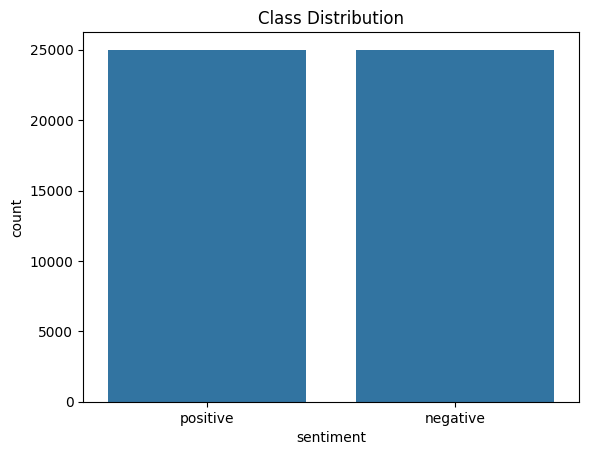

In [10]:
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution')
plt.show()

In [11]:
import re
import nltk
from nltk.corpus import stopwords

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from bs4 import BeautifulSoup

In [14]:
import string
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [15]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

<ipython-input-15-40a71e380a3a>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [16]:
df['review'].head()

,review
0,one reviewers mentioned watching oz episode ex...
1,wonderful little filming technique fashion giv...
2,thought wonderful way spend time hot summer si...
3,basically family little boy thinks zombie clos...
4,petter time visually stunning film mattei offe...


In [17]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment,text_length
0,one reviewers mentioned watching oz episode ex...,1,307
1,wonderful little filming technique fashion giv...,1,162
2,thought wonderful way spend time hot summer si...,1,166
3,basically family little boy thinks zombie clos...,0,138
4,petter time visually stunning film mattei offe...,1,230


In [18]:
df.drop('text_length',axis=1,inplace=True)

In [19]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


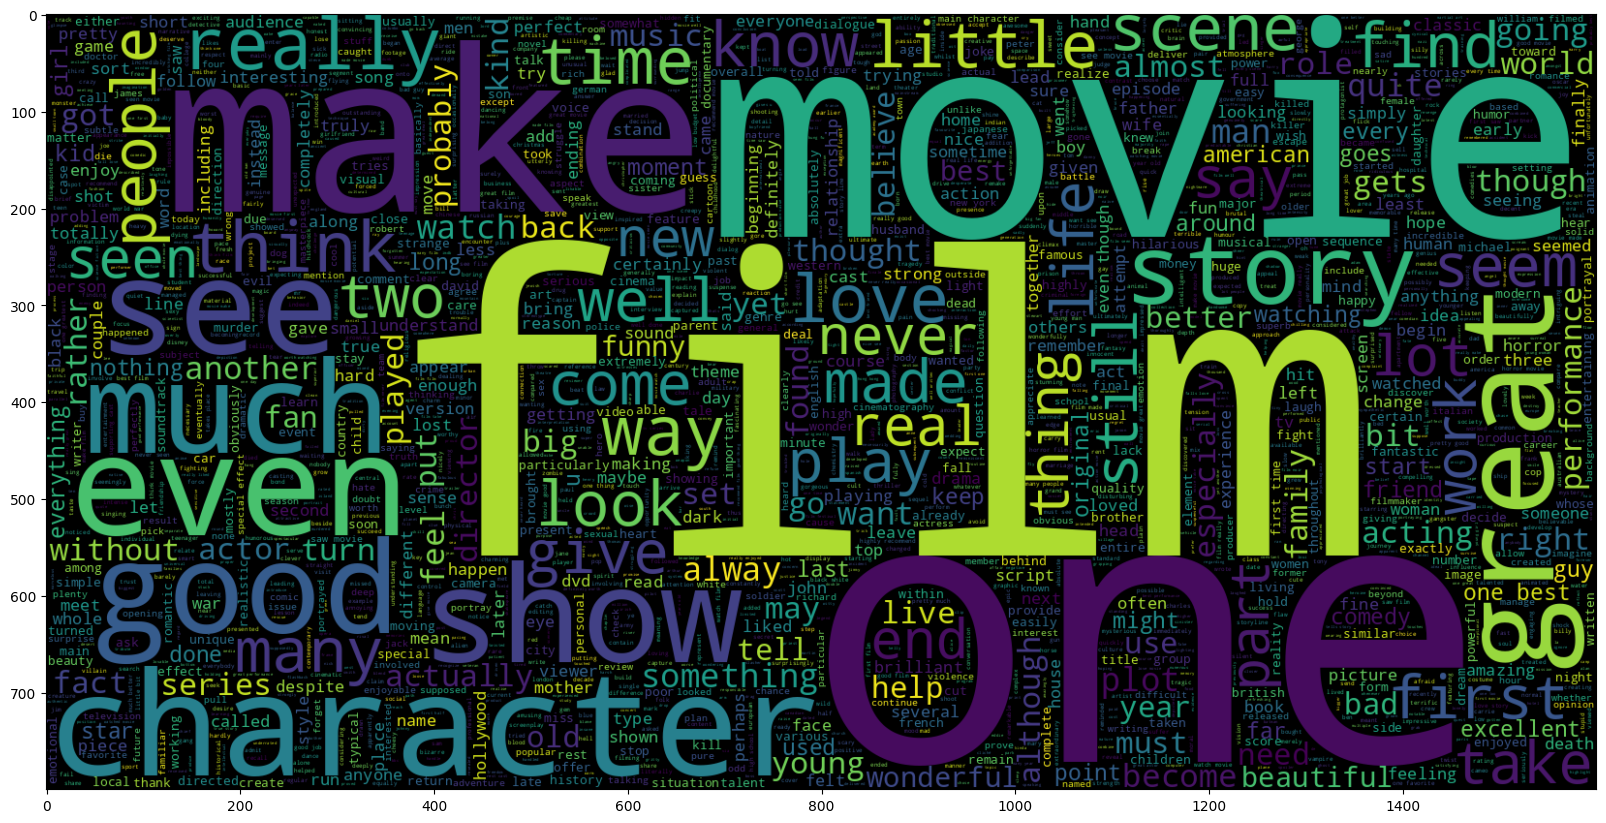

In [20]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

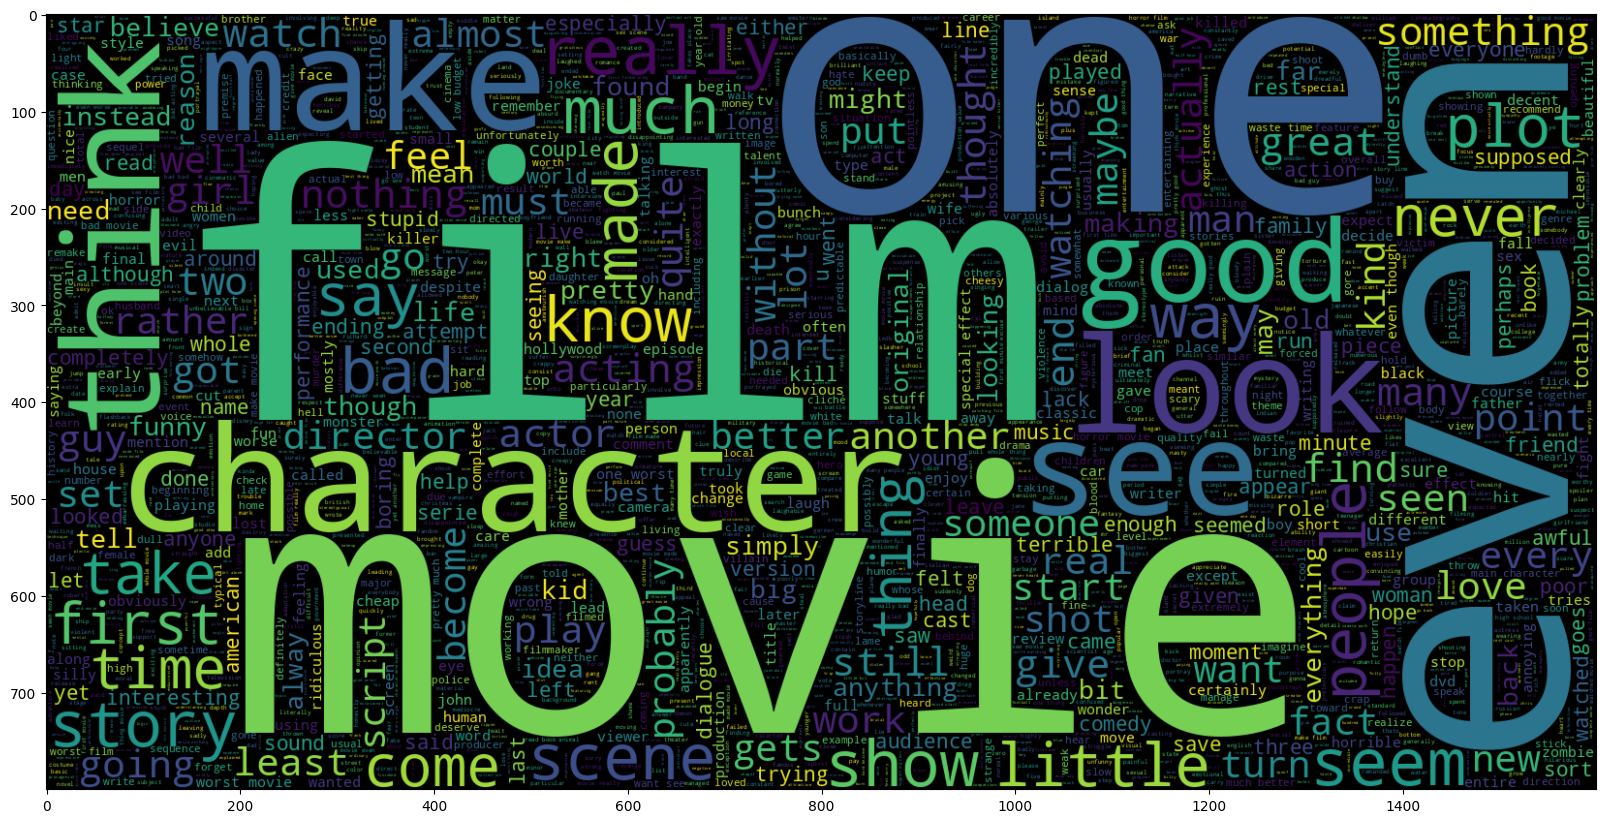

In [21]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

In [22]:
X = df['review']
y = df['sentiment']

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [24]:
# Check the size of the splits
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 40000
Test set size: 10000


## Using BERT Model

In [25]:
!pip install --upgrade transformers

In [26]:
!pip install --upgrade tf_keras

In [27]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [28]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

##Tokenization using BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Tokenize the entire dataset
#truncation=True: Truncates sentences longer than the max_length (128 tokens).
#padding=True: Adds padding to sentences shorter than max_length.
#max_length=128: Sets a maximum length of 128 tokens for each sentence.
#return_tensors='tf': Converts the output into TensorFlow-friendly tensors.
encoding = tokenizer(X.tolist(), truncation=True, padding=True, max_length=128,return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
#Converts the y labels into a TensorFlow tensor for model training.
sentiments = tf.convert_to_tensor(y.values)


#create Tensorflow dataset
#Converts the tokenized text and labels into a TensorFlow dataset. Each data point will contain tokenized input and its corresponding label.
dataset = tf.data.Dataset.from_tensor_slices((dict(encoding), sentiments)).batch(32)

In [30]:
## Load BERT Model for Fine Tuning

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
!pip install -U tf_keras # Keras 2
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [32]:
#Compile and Train the Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

optimizer = Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
#Fine Tune the model
history = model.fit(dataset,epochs=3)

Epoch 1/3
1563/1563 [==============================] - 1345s 817ms/step - loss: 0.3489 - accuracy: 0.8453
Epoch 2/3
1563/1563 [==============================] - 1280s 819ms/step - loss: 0.2453 - accuracy: 0.8999
Epoch 3/3
1563/1563 [==============================] - 1280s 819ms/step - loss: 0.1703 - accuracy: 0.9349


In [ ]:
model.save_pretrained('saved_bert_model')
tokenizer.save_pretrained('saved_bert_model')

## Inference

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('saved_bert_model')
model = TFBertForSequenceClassification.from_pretrained('saved_bert_model')


# Define the inference function
def predict(texts):
    # Tokenize the input texts
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')

    # Extract inputs for the model
    inputs = dict(encodings)

    # Perform inference
    predictions = model(inputs, training=False).logits

    # Convert logits to predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    return predicted_labels

# Example texts to classify
sample_texts = ["I loved this movie, it was fantastic!", "I didn't like the film, it was boring."]

# Get predictions
predictions = predict(sample_texts)

# Print predictions
for text, label in zip(sample_texts, predictions):
    print(f"Text: {text}")
    print(f"Predicted Label: {label}")